In [1]:
!git clone https://github.com/batuozdas/retina_disease_detection

Cloning into 'retina_disease_detection'...
remote: Enumerating objects: 1629, done.
remote: Counting objects: 100% (1629/1629), done.
remote: Compressing objects: 100% (1627/1627), done.
remote: Total 1629 (delta 1), reused 1625 (delta 0), pack-reused 0
Receiving objects: 100% (1629/1629), 99.53 MiB | 5.29 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog, greycomatrix, greycoprops
from skimage.filters import threshold_otsu
import cv2, pathlib, os, glob,time
from sklearn import svm, tree, ensemble, linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,accuracy_score
import seaborn as sns
import random

In [3]:
file_names = {'CNV':[], 'DME':[], 'DRUSEN':[], 'NORMAL': []}
label_names = {'CNV':0, 'DME':1, 'DRUSEN':2, 'NORMAL': 3}

for file in file_names.keys():
    file_names[file].append(os.listdir('/content/retina_disease_detection/Retina_OCT_dataset_2/{}/'.format(file)))

In [4]:
IMAGE_SHAPE = (128,128)
X, y = [], []
for labels, images in file_names.items():
    for image in images[0]:
        img = cv2.imread('/content/retina_disease_detection/Retina_OCT_dataset_2/{}/{}'.format(labels,image),1)
        img[img == 255] = 0
        img_copy = np.copy(img)
        blurred_img = cv2.medianBlur(img,ksize=7)
        gray_img = cv2.cvtColor(blurred_img,cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.5,tileGridSize=(8,8))
        gray_img_hist = clahe.apply(gray_img)
        threshold_val, threshold_img = cv2.threshold(gray_img_hist,40,255,cv2.THRESH_BINARY)
        # Opening operation
        mask = cv2.erode(threshold_img, kernel=np.ones((7, 7)), iterations=1)
        mask2 = cv2.dilate(mask, kernel=np.ones((7, 7)), iterations=1)
        # Closing operation
        mask3 = cv2.dilate(mask2, kernel=np.ones((3, 3)), iterations=1)
        threshold_img_clean = cv2.erode(mask3, kernel=np.ones((3, 3)), iterations=1)
        contours, hierarchy = cv2.findContours(threshold_img_clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = cv2.drawContours(img, [max(contours, key = cv2.contourArea)],-1, (100,120,55), thickness=-1)
        img_copy[contour_image != (100,120,55)] = 0
        resized_img = cv2.resize(img_copy,dsize=IMAGE_SHAPE)
        resized_img = cv2.cvtColor(resized_img,cv2.COLOR_BGR2GRAY)
        X.append(resized_img)
        y.append(label_names[labels])

In [5]:
X = np.array(X)
y = np.array(y)
X.shape

(2000, 128, 128)

In [6]:
# Feature Extraction
dataset = pd.DataFrame()
for image in X:
    df = pd.DataFrame()
    i = 0
    glcm_features = ['energy','correlation','homogeneity','contrast']
    for distance in np.arange(1,6,2):
        for angle in np.arange(0,(3*np.pi/4)+0.1,np.pi/4):
            i += 1
            for feature in glcm_features:
                GLCM = greycomatrix(image,[distance],[angle])
                df['GLCM_{}_{}'.format(feature,i)] = greycoprops(GLCM, prop=feature)[0]

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
    df['HOG_mean'] = np.mean(fd)
    df['HOG_std'] = np.std(fd)

    ksize = 5
    psi = 0
    j = 0
    for theta in np.arange(np.pi / 4, 2 * np.pi, np.pi / 4):
        for sigma in (1, 3, 5, 7):
            for lamda in (np.pi / 4, np.pi, np.pi / 4):
                for gamma in (0.5, 0.9):
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, psi)
                    fimg = cv2.filter2D(image, cv2.CV_8UC3, kernel)
                    fimg_mean = np.mean(fimg)
                    fimg_std = np.std(fimg)
                    df['Gabor_{}_mean'.format(j+1)] = fimg_mean
                    df['Gabor_{}_std'.format(j+1)] = fimg_std
                    j += 1


    dataset = dataset.append(df)

In [7]:
dataset

,GLCM_energy_1,GLCM_correlation_1,GLCM_homogeneity_1,GLCM_contrast_1,GLCM_energy_2,GLCM_correlation_2,GLCM_homogeneity_2,GLCM_contrast_2,GLCM_energy_3,GLCM_correlation_3,GLCM_homogeneity_3,GLCM_contrast_3,GLCM_energy_4,GLCM_correlation_4,GLCM_homogeneity_4,GLCM_contrast_4,GLCM_energy_5,GLCM_correlation_5,GLCM_homogeneity_5,GLCM_contrast_5,GLCM_energy_6,GLCM_correlation_6,GLCM_homogeneity_6,GLCM_contrast_6,GLCM_energy_7,GLCM_correlation_7,GLCM_homogeneity_7,GLCM_contrast_7,GLCM_energy_8,GLCM_correlation_8,GLCM_homogeneity_8,GLCM_contrast_8,GLCM_energy_9,GLCM_correlation_9,GLCM_homogeneity_9,GLCM_contrast_9,GLCM_energy_10,GLCM_correlation_10,GLCM_homogeneity_10,GLCM_contrast_10,...,Gabor_149_mean,Gabor_149_std,Gabor_150_mean,Gabor_150_std,Gabor_151_mean,Gabor_151_std,Gabor_152_mean,Gabor_152_std,Gabor_153_mean,Gabor_153_std,Gabor_154_mean,Gabor_154_std,Gabor_155_mean,Gabor_155_std,Gabor_156_mean,Gabor_156_std,Gabor_157_mean,Gabor_157_std,Gabor_158_mean,Gabor_158_std,Gabor_159_mean,Gabor_159_std,Gabor_160_mean,Gabor_160_std,Gabor_161_mean,Gabor_161_std,Gabor_162_mean,Gabor_162_std,Gabor_163_mean,Gabor_163_std,Gabor_164_mean,Gabor_164_std,Gabor_165_mean,Gabor_165_std,Gabor_166_mean,Gabor_166_std,Gabor_167_mean,Gabor_167_std,Gabor_168_mean,Gabor_168_std
0,0.522516,0.945298,0.555171,274.526267,0.516154,0.925117,0.546128,377.216256,0.521957,0.934264,0.552324,331.823081,0.515848,0.920047,0.546319,402.748775,0.510578,0.885965,0.539179,569.300562,0.502603,0.872136,0.527104,644.916226,0.497460,0.823386,0.520273,898.428062,0.503040,0.854351,0.528569,734.566515,0.504529,0.826138,0.527150,860.327553,0.482482,0.783806,0.502743,1091.166558,...,110.987915,121.111055,101.188965,116.372512,115.268494,122.835180,114.036621,122.484938,24.390930,43.994746,14.207520,31.793912,115.268494,122.835180,114.036621,122.484938,115.248230,122.864798,114.783813,122.738068,21.655823,41.687524,17.607239,36.834013,115.248230,122.864798,114.783813,122.738068,115.220764,122.868759,114.980957,122.802089,21.137756,41.320062,19.007019,38.778490,115.220764,122.868759,114.980957,122.802089
0,0.572127,0.966149,0.630088,104.568836,0.566837,0.953677,0.624019,143.654101,0.576747,0.949431,0.643381,156.629306,0.565716,0.918886,0.613451,251.507037,0.557730,0.902673,0.598962,301.163063,0.552324,0.907396,0.595111,288.505417,0.553105,0.831965,0.581998,524.651500,0.547793,0.835543,0.581775,512.221592,0.552643,0.851047,0.586331,461.574251,0.533435,0.827991,0.561645,540.972425,...,102.848999,120.022374,92.564453,113.622114,106.870056,122.196459,105.673157,121.776072,17.231201,34.778000,9.240356,26.070425,106.870056,122.196459,105.673157,121.776072,106.822266,122.249639,106.370056,122.098596,14.824463,32.721557,11.646057,29.283406,106.822266,122.249639,106.370056,122.098596,106.787720,122.258736,106.554932,122.180973,14.350586,32.347558,12.678894,30.537094,106.787720,122.258736,106.554932,122.180973
0,0.568210,0.951328,0.630798,110.963521,0.560220,0.898821,0.607706,231.592349,0.574797,0.943842,0.642705,128.293307,0.563073,0.938554,0.623810,140.646227,0.551518,0.873868,0.594858,287.754125,0.542410,0.799101,0.574986,461.891156,0.548380,0.802360,0.576951,455.239438,0.548314,0.890779,0.592080,251.108718,0.541771,0.813708,0.577349,424.412729,0.512033,0.678569,0.530430,744.768470,...,103.008545,118.195964,89.777832,110.027299,109.115356,121.196334,107.371277,120.466696,15.119507,26.011894,7.654480,17.140979,109.115356,121.196334,107.371277,120.466696,109.193909,121.266733,108.547241,121.005497,13.027893,24.544453,10.056824,21.011277,109.193909,121.266733,108.547241,121.005497,109.191040,121.275813,108.856812,121.143434,12.623962,24.352617,11.055847,22.484473,109.191040,121.275813,108.856812,121.143434
0,0.289254,0.921521,0.341509,294.259043,0.274386,0.865738,0.320105,503.706801,0.285015,0.865440,0.338275,506.199188,0.274508,0.844516,0.318859,583.315953,0.265347,0.859255,0.310331,526.638250,0.248317,0.779740,0.287631,825.634165,0.247012,0.732614,0.284489,1006.932250,0.248501,0.750018,0.286

In [8]:
X = np.array(dataset)

In [9]:
# firefly algoritması
total_val = np.sum(X)
chi_square_vals = []
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    row_sum = X[i,:].sum()
    col_sum = X[:,j].sum()
    expected_val = (row_sum * col_sum)  / total_val
    chi_square_vals.append(np.sqrt((X[i,j] - expected_val)**2) / expected_val  )


chi_square_vals = np.array(chi_square_vals).reshape(X.shape)
positions = chi_square_vals.T

fitness_function = np.array([10*positions.shape[0] + (positions[i]**2 - 10 * np.cos(2*np.pi*positions[i])).sum() for i in range(positions.shape[0])])
max_iter = 50
gama = 0.02
beta0 = 0.01
alpha = 0.7
delta = 1
iteration = 0
while iteration < max_iter:
    alpha *= 0.97
    for i in range(0,positions.shape[0]):
        for j in range(0,positions.shape[0]):
            if fitness_function[i] > fitness_function[j]:
                r = np.sqrt(((positions[i] - positions[j])**2).sum())
                beta = beta0 * np.exp(-gama * r)
                e = delta * np.random.random()
                positions[i] = positions[i] + beta * np.random.random() * (positions[j] - positions[i]) + alpha * e

            else:
                e = delta * np.random.random()
                positions[i] = positions[i] + alpha + e

        fitness_function[i] = 10 * positions.shape[0] + (positions[i] ** 2 - 10 * np.cos(2 * np.pi * positions[i])).sum()

    firefly_cost = np.array([((fitness_function[i],i)) for i in range(fitness_function.shape[0])])
    sortedArr = firefly_cost[firefly_cost[:,0].argsort()]
    iteration += 1
    print(iteration)

sortedArr = sortedArr[:int(sortedArr.shape[0]*0.8),:]
X_firefly = np.zeros((X.shape[0],sortedArr.shape[0]))
j = 0
for i in np.int32(sortedArr[:,1]):
    X_firefly[:,j] = X[:,i]
    j += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [10]:
sortedArr

array([[5.13112293e+11, 5.00000000e+00],
       [5.13418952e+11, 3.00000000e+00],
       [5.13486043e+11, 1.10000000e+01],
       [5.13507825e+11, 7.00000000e+00],
       [5.13519335e+11, 2.10000000e+01],
       [5.13655233e+11, 1.30000000e+01],
       [5.13718435e+11, 1.00000000e+01],
       [5.13726816e+11, 1.20000000e+01],
       [5.13753363e+11, 6.00000000e+00],
       [5.13753591e+11, 1.00000000e+00],
       [5.13874987e+11, 8.00000000e+00],
       [5.13916225e+11, 2.70000000e+01],
       [5.13996280e+11, 1.70000000e+01],
       [5.14039203e+11, 3.50000000e+01],
       [5.14060254e+11, 0.00000000e+00],
       [5.14263622e+11, 2.00000000e+00],
       [5.14302960e+11, 4.00000000e+00],
       [5.14340842e+11, 3.20000000e+01],
       [5.14469929e+11, 1.90000000e+01],
       [5.14495967e+11, 3.90000000e+01],
       [5.14502735e+11, 2.60000000e+01],
       [5.14518649e+11, 9.00000000e+00],
       [5.14593919e+11, 2.50000000e+01],
       [5.14698480e+11, 1.40000000e+01],
       [5.147210

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train_firefly, X_test_firefly, y_train_firefly, y_test_firefly = train_test_split(X_firefly,y,test_size=0.2,random_state=0)
print(X_train.shape)
X_train_firefly.shape

(1600, 386)


(1600, 308)

In [12]:
lr_model = linear_model.LogisticRegression(C=30,solver='liblinear')
lr_model_f = linear_model.LogisticRegression(C=30,solver='liblinear')
lr_model.fit(X_train,y_train)
lr_model_f.fit(X_train_firefly,y_train_firefly)

LogisticRegression(C=30, solver='liblinear')

In [13]:
y_pred = lr_model.predict(X_test)
y_pred_firefly = lr_model_f.predict(X_test_firefly)

In [14]:
cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
df_cr = pd.DataFrame(cr).transpose()
df_cr = df_cr.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr

,precision,recall,f1-score,support
CNV,0.919643,0.962617,0.940639,107.0000
DME,0.846154,0.827957,0.836957,93.0000
DRUSEN,0.829787,0.772277,0.800000,101.0000
NORMAL,0.844660,0.878788,0.861386,99.0000
accuracy,0.862500,0.862500,0.862500,0.8625
macro avg,0.860061,0.860410,0.859745,400.0000
weighted avg,0.861310,0.862500,0.861406,400.0000


In [15]:
cr_firefly = classification_report(y_test_firefly, y_pred_firefly, output_dict=True, zero_division=0)
df_cr_firefly = pd.DataFrame(cr_firefly).transpose()
df_cr_firefly = df_cr_firefly.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr_firefly

,precision,recall,f1-score,support
CNV,0.911504,0.962617,0.936364,107.000
DME,0.835165,0.817204,0.826087,93.000
DRUSEN,0.851064,0.792079,0.820513,101.000
NORMAL,0.852941,0.878788,0.865672,99.000
accuracy,0.865000,0.865000,0.865000,0.865
macro avg,0.862669,0.862672,0.862159,400.000
weighted avg,0.864000,0.865000,0.863976,400.000


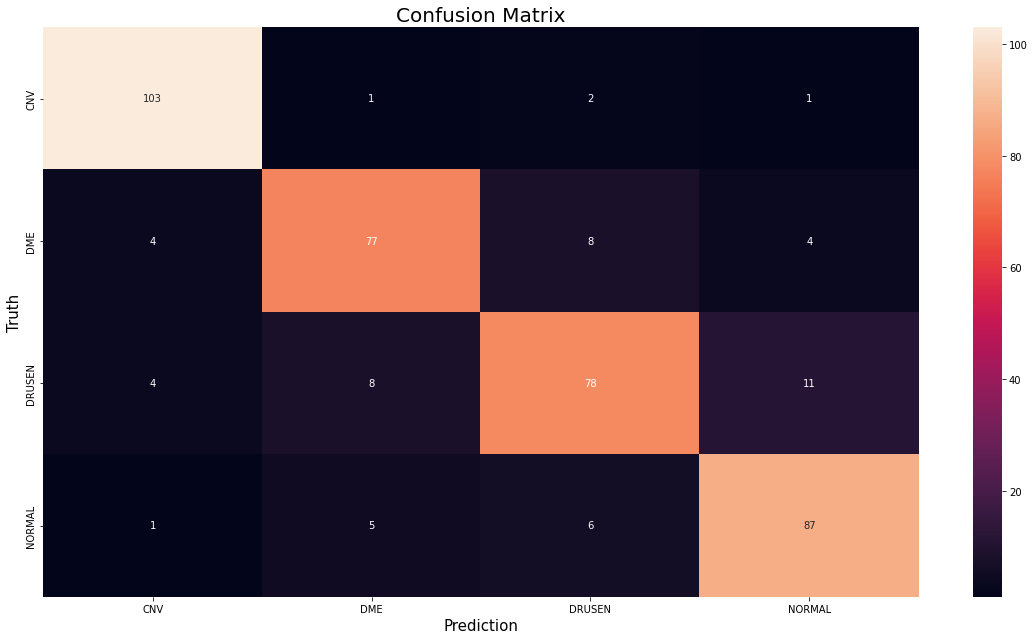

In [16]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

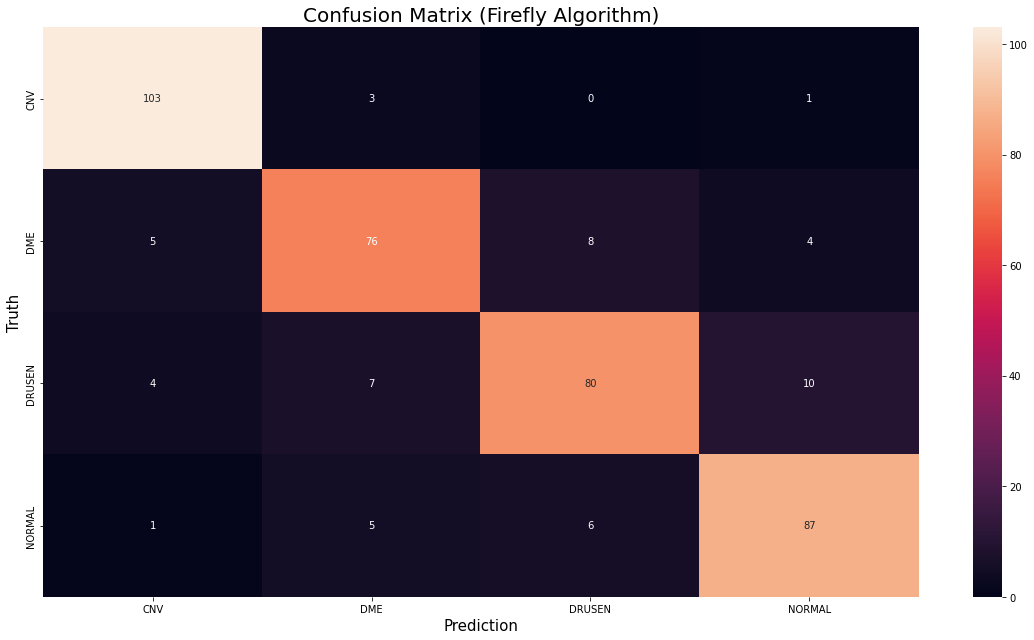

In [17]:
cm_firefly = confusion_matrix(y_test_firefly, y_pred_firefly)
df_cm_firefly = pd.DataFrame(cm_firefly, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm_firefly, annot=True, fmt='d')
plt.title('Confusion Matrix (Firefly Algorithm)', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

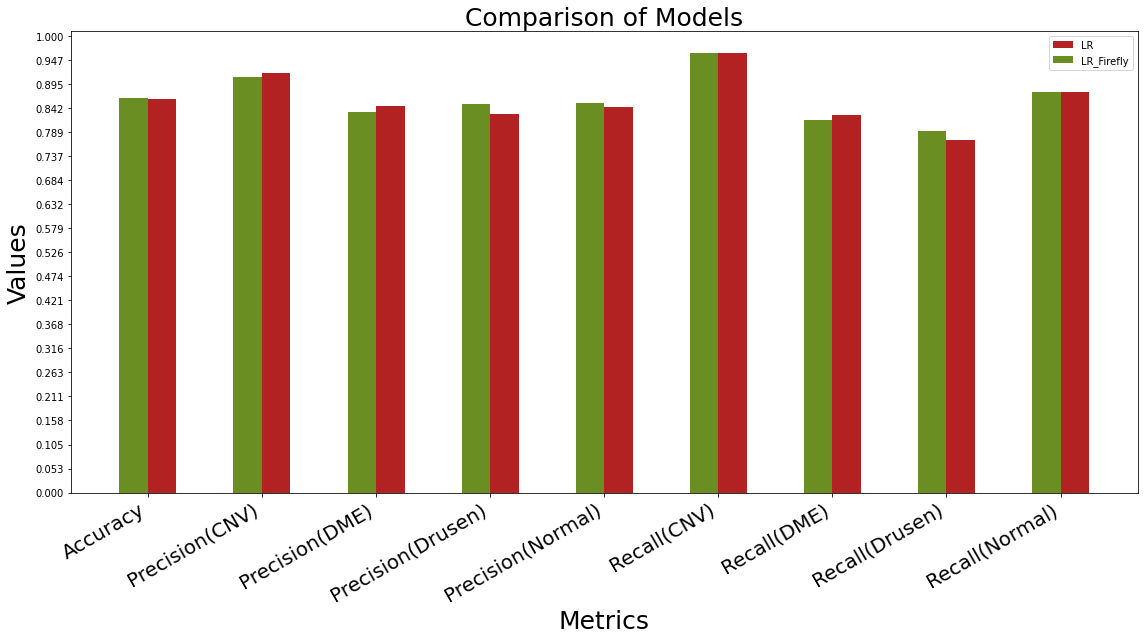

In [18]:
# Comparison of Models
x_labels = ['Accuracy','Precision(CNV)','Precision(DME)','Precision(Drusen)','Precision(Normal)',
            'Recall(CNV)','Recall(DME)','Recall(Drusen)','Recall(Normal)']
x_indexes = np.arange(0,len(x_labels))

y_values = [[df_cr.loc['accuracy'], df_cr_firefly.loc['accuracy']], 
            [df_cr.loc['CNV','precision'], df_cr_firefly.loc['CNV','precision']],
            [df_cr.loc['DME','precision'], df_cr_firefly.loc['DME','precision']],
            [df_cr.loc['DRUSEN','precision'], df_cr_firefly.loc['DRUSEN','precision']],
            [df_cr.loc['NORMAL','precision'],df_cr_firefly.loc['NORMAL','precision']],
            [df_cr.loc['CNV','recall'], df_cr_firefly.loc['CNV','recall']],
            [df_cr.loc['DME','recall'], df_cr_firefly.loc['DME','recall']],
            [df_cr.loc['DRUSEN','recall'], df_cr_firefly.loc['DRUSEN','recall']],
            [df_cr.loc['NORMAL','recall'], df_cr_firefly.loc['NORMAL','recall']]]


width = 0.25
colors = ['firebrick','olivedrab']
labels = ['LR','LR_Firefly']
k = 0
fig = plt.figure(2,figsize=(16,9))
for i in range(len(y_values)):
  val = -0.125
  for j in range(len(y_values[i])):
    plt.bar(x_indexes[k] - val,y_values[i][j],width = width, color = colors[j])
    val += 0.25
  k += 1

plt.xticks(ticks=x_indexes,labels=x_labels,fontsize = 20)
plt.yticks(np.linspace(0,1,20))
plt.title("Comparison of Models",fontsize=25)
plt.xlabel("Metrics",fontsize=25)
plt.ylabel("Values",fontsize=25)
plt.legend(loc='best',labels=labels)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()